## State of the Union Transcription Comparison Tool

Explanation
Reading CSV Files:

The read_csv_files function recursively reads all CSV files in the specified directory and subdirectories.
Each CSV file is read into a separate DataFrame, and the source file path is stored in a new column.
Processing Transcriptions:

Each DataFrame is processed individually to clean the text, tokenize, and perform POS tagging and NER.
This keeps the analyses of each transcription separate.
Generating Embeddings and Calculating Similarity:

Embeddings are generated for the entire cleaned transcript text of each file.
The embeddings are stored in a list along with the corresponding file names.
The cosine similarity matrix is computed to compare each transcription against all others.
Topic Modeling with LDA:

LDA is performed on the tokens of each transcription separately.
The topics for each transcription are printed out, allowing you to compare the topics between different transcriptions.


pip install pandas numpy nltk spacy sentence-transformers scikit-learn
python -m spacy download en_core_web_sm


In [ ]:
pip install openpyxl

In [3]:
transcripts_folder = "state_of_union_data/sotu_speeches"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\mrhal\anaconda3\envs\NLTKpipeline-env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


DataFrame shape for state_of_union_data/sotu_speeches\1790-01-08_George_Washington.csv: (1, 6)
Cleaned transcripts for state_of_union_data/sotu_speeches\1790-01-08_George_Washington.csv: 0    fellowcitizens of the senate and house of repr...
Name: cleaned_transcript, dtype: object
Embedding for state_of_union_data/sotu_speeches\1790-01-08_George_Washington.csv: (384,)
Skipping LDA for state_of_union_data/sotu_speeches\1790-01-08_George_Washington.csv: cannot compute LDA over an empty collection (no terms)
DataFrame shape for state_of_union_data/sotu_speeches\1790-12-08_George_Washington.csv: (1, 6)
Cleaned transcripts for state_of_union_data/sotu_speeches\1790-12-08_George_Washington.csv: 0    fellowcitizens of the senate and house of repr...
Name: cleaned_transcript, dtype: object
Embedding for state_of_union_data/sotu_speeches\1790-12-08_George_Washington.csv: (384,)
Skipping LDA for state_of_union_data/sotu_speeches\1790-12-08_George_Washington.csv: cannot compute LDA over an empty 

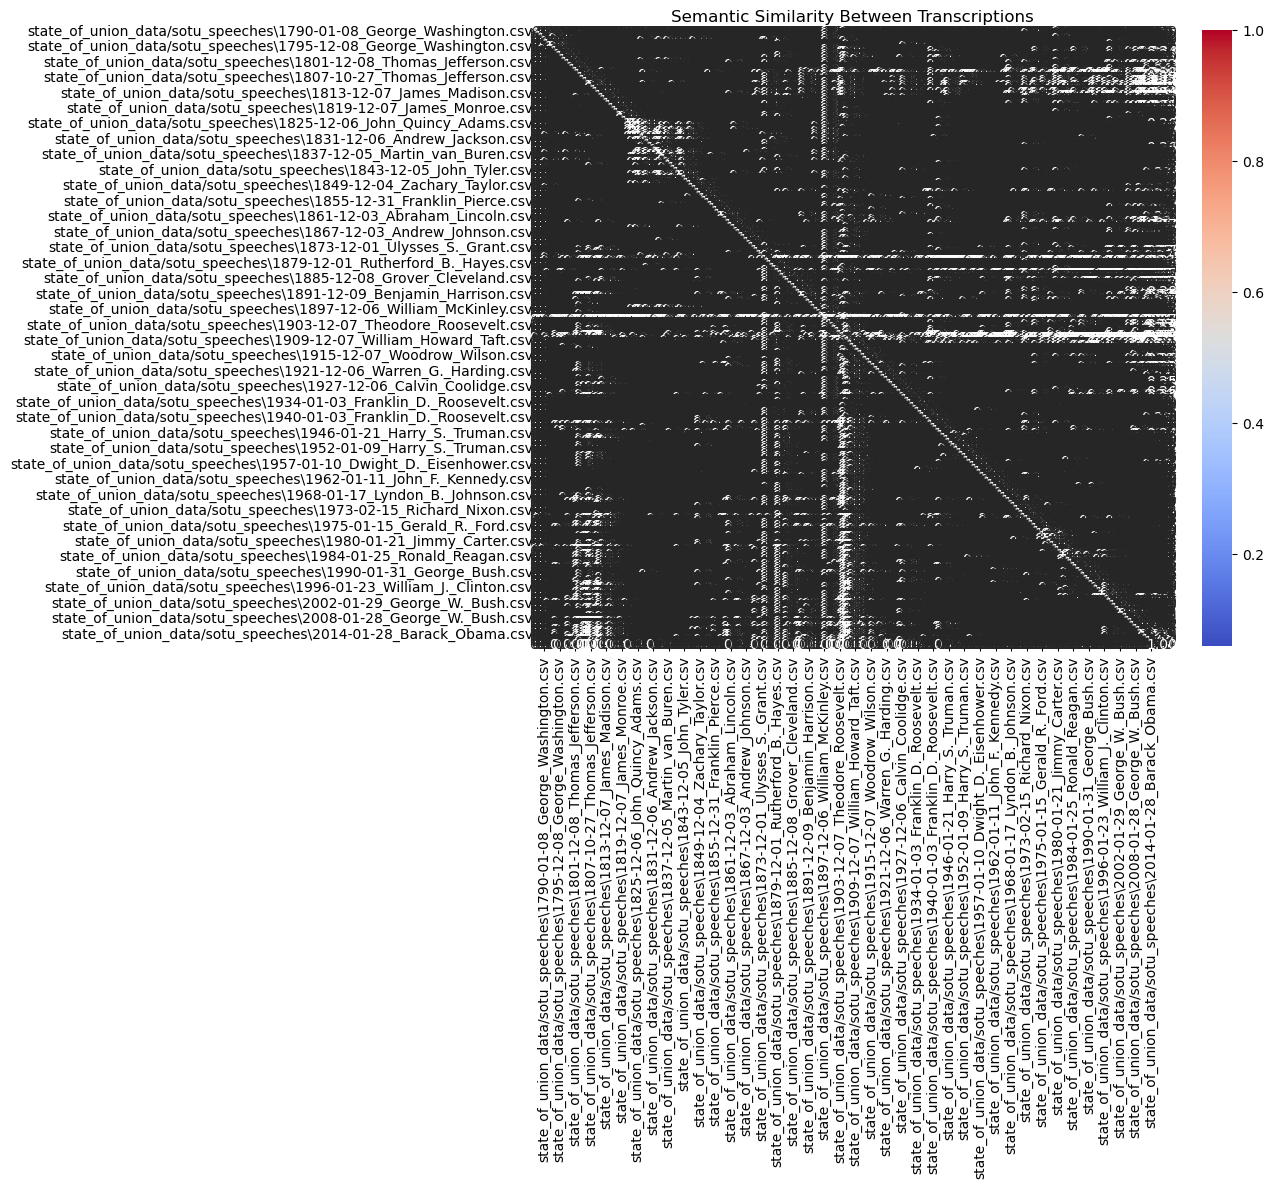

In [4]:
import os
import glob
import pandas as pd
import re
import nltk
import spacy
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Setup
nltk.download('punkt')
nltk.download('stopwords')
file_path = transcripts_folder  # Update this if needed
nlp = spacy.load('en_core_web_sm')
stop_words = set(nltk.corpus.stopwords.words('english'))
model = SentenceTransformer('all-MiniLM-L6-v2')

# Functions
def read_csv_files(directory):
    csv_files = glob.glob(os.path.join(directory, '**', '*.csv'), recursive=True)
    data_frames = []
    for file in csv_files:
        df = pd.read_csv(file)
        df['source_file'] = file  # Keep track of the source file
        data_frames.append(df)
    return data_frames

def preprocess_text(text):
    # Lowercase conversion
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def spacy_analysis(text):
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return pos_tags, entities

def perform_lda(tokens_list, num_topics=5):
    # Check if there are any non-empty token lists
    if not any(tokens_list):
        raise ValueError("Cannot compute LDA over an empty collection (no terms)")
    
    dictionary = Dictionary(tokens_list)
    dictionary.filter_extremes(no_below=1, no_above=0.5)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list if tokens]
    
    if len(corpus) == 0:
        raise ValueError("Corpus is empty after filtering. No valid tokens found.")
    
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    return lda, corpus, dictionary

# Execution
directory = file_path
transcript_dfs = read_csv_files(directory)

embeddings_list = []
file_names = []
lda_models = []

for df in transcript_dfs:
    # Ensure the 'transcript' column exists before processing
    if 'transcript' not in df.columns:
        print(f"'transcript' column not found in {df['source_file'].iloc[0]}")
        continue
    
    print(f"DataFrame shape for {df['source_file'].iloc[0]}: {df.shape}")
    
    # Preprocess transcript column
    df['cleaned_transcript'] = df['transcript'].apply(preprocess_text)
    print(f"Cleaned transcripts for {df['source_file'].iloc[0]}: {df['cleaned_transcript'].head()}")

    # Tokenize the cleaned transcripts
    df['tokens'] = df['cleaned_transcript'].apply(tokenize_text)

    # Filter out rows with empty tokens
    df = df[df['tokens'].apply(lambda tokens: len(tokens) > 0)]
    
    if df.empty:
        print(f"No valid tokens found in {df['source_file'].iloc[0]}, skipping LDA.")
        continue

    # Apply spacy_analysis to extract POS tags and entities
    df[['pos_tags', 'entities']] = df['cleaned_transcript'].apply(
        lambda x: pd.Series(spacy_analysis(x))
    )

    # Generate embeddings for the entire text
    text = ' '.join(df['cleaned_transcript'])
    embedding = model.encode(text)
    print(f"Embedding for {df['source_file'].iloc[0]}: {embedding.shape}")

    if embedding is not None and embedding.size > 0:
        embeddings_list.append(embedding)
        file_names.append(df['source_file'].iloc[0])

        # Perform LDA on tokenized text
        tokens_list = df['tokens'].tolist()
        
        try:
            lda_model, corpus, dictionary = perform_lda(tokens_list)
            lda_models.append({
                'model': lda_model,
                'corpus': corpus,
                'dictionary': dictionary,
                'source_file': df['source_file'].iloc[0]
            })
        except ValueError as ve:
            print(f"Skipping LDA for {df['source_file'].iloc[0]}: {ve}")
    else:
        print(f"No valid embedding for {df['source_file'].iloc[0]}.")

# Compute similarity matrix
if embeddings_list:
    embeddings_array = np.vstack(embeddings_list)
    similarity_matrix = cosine_similarity(embeddings_array)
    similarity_df = pd.DataFrame(similarity_matrix, index=file_names, columns=file_names)
    print(similarity_df)

    # Visualize similarity matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Semantic Similarity Between Transcriptions')
    plt.show()
else:
    print("No embeddings to compute similarity matrix.")

# Print topics from LDA models
for lda_info in lda_models:
    print(f"Topics for {lda_info['source_file']}:")
    topics = lda_info['model'].print_topics(num_words=5)
    for topic in topics:
        print(topic)
    print('\n')


In [2]:
import os
import glob
import pandas as pd
import re
import nltk
import spacy
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Setup
nltk.download('punkt')
nltk.download('stopwords')
file_path = transcripts_folder  # Update this if needed
nlp = spacy.load('en_core_web_sm')
stop_words = set(nltk.corpus.stopwords.words('english'))
model = SentenceTransformer('all-MiniLM-L6-v2')

# Functions
def read_csv_files(directory):
    csv_files = glob.glob(os.path.join(directory, '**', '*.csv'), recursive=True)
    data_frames = []
    for file in csv_files:
        df = pd.read_csv(file)
        df['source_file'] = file  # Keep track of the source file
        data_frames.append(df)
    return data_frames

def preprocess_text(text):
    # Lowercase conversion
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def spacy_analysis(text):
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return pos_tags, entities

def perform_lda(tokens_list, num_topics=5):
    dictionary = Dictionary(tokens_list)
    dictionary.filter_extremes(no_below=1, no_above=0.5)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    return lda, corpus, dictionary

# Execution
directory = file_path
transcript_dfs = read_csv_files(directory)

embeddings_list = []
file_names = []
lda_models = []

for df in transcript_dfs:
    # Ensure the 'transcript' column exists before processing
    if 'transcript' not in df.columns:
        print(f"'transcript' column not found in {df['source_file'].iloc[0]}")
        continue
    
    print(f"DataFrame shape for {df['source_file'].iloc[0]}: {df.shape}")
    
    # Preprocess transcript column
    df['cleaned_transcript'] = df['transcript'].apply(preprocess_text)
    print(f"Cleaned transcripts for {df['source_file'].iloc[0]}: {df['cleaned_transcript'].head()}")

    # Tokenize the cleaned transcripts
    df['tokens'] = df['cleaned_transcript'].apply(tokenize_text)

    # Apply spacy_analysis to extract POS tags and entities
    df[['pos_tags', 'entities']] = df['cleaned_transcript'].apply(
        lambda x: pd.Series(spacy_analysis(x))
    )

    # Generate embeddings for the entire text
    text = ' '.join(df['cleaned_transcript'])
    embedding = model.encode(text)
    print(f"Embedding for {df['source_file'].iloc[0]}: {embedding.shape}")

    if embedding is not None and embedding.size > 0:
        embeddings_list.append(embedding)
        file_names.append(df['source_file'].iloc[0])

        # Perform LDA on tokenized text
        tokens_list = df['tokens'].tolist()
        lda_model, corpus, dictionary = perform_lda(tokens_list)
        lda_models.append({
            'model': lda_model,
            'corpus': corpus,
            'dictionary': dictionary,
            'source_file': df['source_file'].iloc[0]
        })
    else:
        print(f"No valid embedding for {df['source_file'].iloc[0]}.")

# Compute similarity matrix
if embeddings_list:
    embeddings_array = np.vstack(embeddings_list)
    similarity_matrix = cosine_similarity(embeddings_array)
    similarity_df = pd.DataFrame(similarity_matrix, index=file_names, columns=file_names)
    print(similarity_df)

    # Visualize similarity matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Semantic Similarity Between Transcriptions')
    plt.show()
else:
    print("No embeddings to compute similarity matrix.")

# Print topics from LDA models
for lda_info in lda_models:
    print(f"Topics for {lda_info['source_file']}:")
    topics = lda_info['model'].print_topics(num_words=5)
    for topic in topics:
        print(topic)
    print('\n')


c:\Users\mrhal\anaconda3\envs\NLTKpipeline-env\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\mrhal\anaconda3\envs\NLTKpipeline-env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/tran

DataFrame shape for state_of_union_data/sotu_speeches\1790-01-08_George_Washington.csv: (1, 6)
Cleaned transcripts for state_of_union_data/sotu_speeches\1790-01-08_George_Washington.csv: 0    fellowcitizens of the senate and house of repr...
Name: cleaned_transcript, dtype: object
Embedding for state_of_union_data/sotu_speeches\1790-01-08_George_Washington.csv: (384,)


ValueError: cannot compute LDA over an empty collection (no terms)

In [5]:
import os
import glob
import pandas as pd
import re
import nltk
import spacy
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Setup
nltk.download('punkt')
nltk.download('stopwords')
file_path = transcripts_folder  # Update this if needed
nlp = spacy.load('en_core_web_sm')
stop_words = set(nltk.corpus.stopwords.words('english'))
model = SentenceTransformer('all-MiniLM-L6-v2')

# Functions
def read_csv_files(directory):
    csv_files = glob.glob(os.path.join(directory, '**', '*.csv'), recursive=True)
    data_frames = []
    for file in csv_files:
        df = pd.read_csv(file)
        df['source_file'] = file  # Keep track of the source file
        data_frames.append(df)
    return data_frames

def preprocess_text(text):
    # Lowercase conversion
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def spacy_analysis(text):
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return pos_tags, entities

def perform_lda(tokens_list, num_topics=5):
    dictionary = Dictionary(tokens_list)
    dictionary.filter_extremes(no_below=1, no_above=0.5)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    return lda, corpus, dictionary

# Execution
directory = file_path
transcript_dfs = read_csv_files(directory)

embeddings_list = []
file_names = []
lda_models = []

for df in transcript_dfs:
    print(f"DataFrame shape for {df['source_file'].iloc[0]}: {df.shape}")
    df['cleaned_transcript'] = df['text'].apply(preprocess_text)
    print(f"Cleaned transcripts for {df['source_file'].iloc[0]}: {df['cleaned_transcript'].head()}")

    df['tokens'] = df['cleaned_transcript'].apply(tokenize_text)
    df[['pos_tags', 'entities']] = df['cleaned_transcript'].apply(
        lambda x: pd.Series(spacy_analysis(x))
    )

    # Generate embeddings
    text = ' '.join(df['cleaned_transcript'])
    embedding = model.encode(text)
    print(f"Embedding for {df['source_file'].iloc[0]}: {embedding.shape}")

    if embedding is not None and embedding.size > 0:
        embeddings_list.append(embedding)
        file_names.append(df['source_file'].iloc[0])

        # Perform LDA
        tokens_list = df['tokens'].tolist()
        lda_model, corpus, dictionary = perform_lda(tokens_list)
        lda_models.append({
            'model': lda_model,
            'corpus': corpus,
            'dictionary': dictionary,
            'source_file': df['source_file'].iloc[0]
        })
    else:
        print(f"No valid embedding for {df['source_file'].iloc[0]}.")

# Compute similarity matrix
if embeddings_list:
    embeddings_array = np.vstack(embeddings_list)
    similarity_matrix = cosine_similarity(embeddings_array)
    similarity_df = pd.DataFrame(similarity_matrix, index=file_names, columns=file_names)
    print(similarity_df)

    # Visualize similarity matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Semantic Similarity Between Transcriptions')
    plt.show()
else:
    print("No embeddings to compute similarity matrix.")

# Print topics from LDA models
for lda_info in lda_models:
    print(f"Topics for {lda_info['source_file']}:")
    topics = lda_info['model'].print_topics(num_words=5)
    for topic in topics:
        print(topic)
    print('\n')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\mrhal\anaconda3\envs\NLTKpipeline-env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


DataFrame shape for state_of_union_data/sotu_speeches\1790-01-08_George_Washington.csv: (1, 6)
Cleaned transcripts for state_of_union_data/sotu_speeches\1790-01-08_George_Washington.csv: 0    fellowcitizens of the senate and house of repr...
Name: cleaned_transcript, dtype: object
Embedding for state_of_union_data/sotu_speeches\1790-01-08_George_Washington.csv: (384,)


ValueError: cannot compute LDA over an empty collection (no terms)

In [ ]:
import os
import glob
import pandas as pd
import re
import nltk
import spacy
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Setup
nltk.download('punkt')
nltk.download('stopwords')
file_path = 'data/Interviews'  # Updated to use forward slashes
nlp = spacy.load('en_core_web_sm')
stop_words = set(nltk.corpus.stopwords.words('english'))
model = SentenceTransformer('all-MiniLM-L6-v2')

# Functions
def read_csv_files(directory):
    csv_files = glob.glob(os.path.join(directory, '**', '*.csv'), recursive=True)
    print(f"Found {len(csv_files)} CSV files in '{directory}' and its subdirectories.")
    
    data_frames = []
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            if 'text' not in df.columns:
                print(f"Warning: 'text' column not found in {file}. Skipping this file.")
                continue
            df['source_file'] = file  # Keep track of the source file
            data_frames.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")
    return data_frames

def preprocess_text(text):
    # Lowercase conversion
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def spacy_analysis(text):
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return pos_tags, entities

def perform_lda(tokens_list, num_topics=5):
    dictionary = Dictionary(tokens_list)
    dictionary.filter_extremes(no_below=1, no_above=0.5)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
    if not corpus:
        print("Warning: Corpus is empty. Skipping LDA.")
        return None, None, None
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    return lda, corpus, dictionary

def is_valid_text(text):
    if isinstance(text, str) and text.strip():
        return True
    return False

# Execution
directory = file_path
transcript_dfs = read_csv_files(directory)

if not transcript_dfs:
    print("No valid CSV files found. Exiting script.")
    exit()

embeddings_list = []
file_names = []
lda_models = []

for idx, df in enumerate(transcript_dfs):
    print(f"\nProcessing file {idx + 1}/{len(transcript_dfs)}: {df['source_file'].iloc[0]}")
    
    # Preprocess text with validity check
    df['cleaned_transcript'] = df['text'].apply(lambda x: preprocess_text(x) if is_valid_text(x) else "")
    
    # Check if 'cleaned_transcript' is not empty
    if df['cleaned_transcript'].isnull().all() or df['cleaned_transcript'].str.len().max() == 0:
        print(f"Warning: All transcripts are empty after preprocessing in {df['source_file'].iloc[0]}. Skipping this file.")
        continue
    
    # Tokenize text
    df['tokens'] = df['cleaned_transcript'].apply(tokenize_text)
    
    # Perform Spacy analysis
    df[['pos_tags', 'entities']] = df['cleaned_transcript'].apply(
        lambda x: pd.Series(spacy_analysis(x))
    )
    
    # Generate embeddings
    text = ' '.join(df['cleaned_transcript'])
    if not text.strip():
        print(f"Warning: Combined text is empty for {df['source_file'].iloc[0]}. Skipping embedding.")
        continue
    try:
        embedding = model.encode(text)
        embeddings_list.append(embedding)
        file_names.append(df['source_file'].iloc[0])
        print("Embedding generated and appended successfully.")
    except Exception as e:
        print(f"Error generating embedding for {df['source_file'].iloc[0]}: {e}")
        continue
    
    # Perform LDA
    tokens_list = df['tokens'].tolist()
    if not tokens_list:
        print(f"Warning: No tokens to perform LDA for {df['source_file'].iloc[0]}. Skipping LDA.")
        continue
    try:
        lda_model, corpus, dictionary = perform_lda(tokens_list)
        if lda_model is not None:
            lda_models.append({
                'model': lda_model,
                'corpus': corpus,
                'dictionary': dictionary,
                'source_file': df['source_file'].iloc[0]
            })
            print("LDA model trained and appended successfully.")
    except Exception as e:
        print(f"Error performing LDA for {df['source_file'].iloc[0]}: {e}")

# Compute similarity matrix
if embeddings_list:
    embeddings_array = np.vstack(embeddings_list)
    similarity_matrix = cosine_similarity(embeddings_array)
    similarity_df = pd.DataFrame(similarity_matrix, index=file_names, columns=file_names)
    print("\nSimilarity Matrix:")
    print(similarity_df)
    
    # Visualize similarity matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Semantic Similarity Between Transcriptions')
    plt.show()
else:
    print("No embeddings were generated. Please check the CSV files and preprocessing steps.")

# Print topics from LDA models
for lda_info in lda_models:
    print(f"\nTopics for {lda_info['source_file']}:")
    topics = lda_info['model'].print_topics(num_words=5)
    for topic in topics:
        print(topic)
    print('\n')


# Semantic Similarity Sentence Matcher

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm import tqdm  # To track progress
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import display, HTML
import plotly.express as px

# 1. Define key sentences
key_sentences = [
    "How do you support student learning in your classroom?",
    # Add more key sentences as needed
]

# 2. Generate embeddings for key sentences
model = SentenceTransformer('all-MiniLM-L6-v2')
key_embeddings = model.encode(key_sentences)

# 3. Read and process transcripts
def read_transcript_csvs(directory):
    # Use '**/*.csv' to match CSV files in all subdirectories
    csv_files = glob.glob(os.path.join(directory, '**', '*.csv'), recursive=True)
    print(f"Found {len(csv_files)} CSV files in '{directory}' and its subdirectories.")
    
    transcript_data = []
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            # Verify necessary columns
            required_columns = ['text', 'sentence_number']
            for col in required_columns:
                if col not in df.columns:
                    print(f"Warning: '{col}' column missing in {file}. Skipping this file.")
                    raise ValueError(f"Missing '{col}' column.")
            # Add 'speaker' column if missing
            if 'speaker' not in df.columns:
                df['speaker'] = 'Unknown'
            # Capture relative path for 'source_file' to ensure uniqueness
            relative_path = os.path.relpath(file, directory)
            df['source_file'] = relative_path  # Use relative path instead of basename
            transcript_data.append(df)
            print(f"Successfully processed {relative_path}.")
        except Exception as e:
            print(f"Error reading {file}: {e}")
    return transcript_data

transcript_data = read_transcript_csvs(transcripts_folder)

# Debugging: Check 'source_file' in each DataFrame
for idx, df in enumerate(transcript_data):
    print(f"Transcript {idx + 1}: {df['source_file'].iloc[0]}")
    print(f"Columns: {df.columns.tolist()}\n")

# Preprocess function for text
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ''

def compute_embeddings_in_batches(texts, model, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
        batch = texts[i:i+batch_size]
        batch_embeddings = model.encode(batch)
        embeddings.extend(batch_embeddings)
    return embeddings

# Use the function for processing embeddings
for idx, df in enumerate(transcript_data):
    print(f"Processing embeddings for Transcript {idx + 1}: {df['source_file'].iloc[0]}")
    df['cleaned_text'] = df['text'].apply(preprocess_text)
    df['embedding'] = compute_embeddings_in_batches(df['cleaned_text'].tolist(), model)

# 4. Calculate similarity scores
similarity_threshold = 0.55  # Adjust as needed
results = []

for key_idx, key_sentence in enumerate(key_sentences):
    key_embedding = key_embeddings[key_idx]
    for df in transcript_data:
        source_file = df['source_file'].values[0] if 'source_file' in df.columns else 'Unknown'
        if source_file == 'Unknown':
            print(f"Warning: 'source_file' missing for one of the transcripts. Assigning as 'Unknown'.")
        # Ensure embeddings are present
        if 'embedding' not in df.columns or df['embedding'].isnull().all():
            print(f"Warning: No embeddings found in {source_file}. Skipping similarity computation.")
            continue
        try:
            transcript_embeddings = np.vstack(df['embedding'].values)
        except ValueError as ve:
            print(f"Error stacking embeddings in {source_file}: {ve}. Skipping.")
            continue
        similarities = cosine_similarity([key_embedding], transcript_embeddings)[0]
        df[f'similarity_with_key_{key_idx}'] = similarities
        similar_sentences = df[df[f'similarity_with_key_{key_idx}'] >= similarity_threshold]
        if not similar_sentences.empty:
            for idx, row in similar_sentences.iterrows():
                # Ensure 'source_file' is present and valid
                results.append({
                    'source_file': source_file,
                    'sentence_number': row['sentence_number'],
                    'text': row['text'],  # 'text' contains the transcript sentences
                    'speaker': row['speaker'],  # Include speaker information if needed
                    'similarity_score': row[f'similarity_with_key_{key_idx}'],
                    'key_sentence': key_sentence,
                    'key_sentence_index': key_idx
                })

# Create a DataFrame to hold results
results_df = pd.DataFrame(results)

# Check if 'source_file' is present and print a sample of results
print("\nColumns in results_df:", results_df.columns.tolist())
if not results_df.empty:
    print(results_df.head())
else:
    print("Warning: 'results_df' is empty. No similar sentences found above the threshold.")

# 5. Visualize the results
if not results_df.empty:
    # A. Bar plot of occurrences
    occurrences = results_df.groupby(['source_file', 'key_sentence']).size().reset_index(name='counts')
    
    for key_sentence in key_sentences:
        key_data = occurrences[occurrences['key_sentence'] == key_sentence]
        plt.figure(figsize=(10, 6))
        sns.barplot(x='source_file', y='counts', data=key_data)
        plt.title(f"Occurrences of sentences similar to: '{key_sentence}'")
        plt.xticks(rotation=45)
        plt.ylabel('Number of Similar Sentences')
        plt.xlabel('Transcript File')
        plt.tight_layout()
        plt.show()
    
    # B. Scatter plot of sentence positions
    for df in transcript_data:
        transcript_name = df['source_file'].iloc[0]
        plt.figure(figsize=(12, 2))
        has_similar_sentences = False
        for key_idx, key_sentence in enumerate(key_sentences):
            similar_sentences = df[df[f'similarity_with_key_{key_idx}'] >= similarity_threshold]
            if not similar_sentences.empty:
                has_similar_sentences = True
                plt.scatter(
                    similar_sentences['sentence_number'],
                    [key_idx]*len(similar_sentences),
                    label=f"Key {key_idx}: {key_sentence[:30]}...",
                    marker='|',
                    s=200
                )
        
        if has_similar_sentences:
            plt.title(f"Positions of Similar Sentences in {transcript_name}")
            plt.xlabel('Sentence Number')
            plt.xticks(rotation=0)
            plt.yticks(range(len(key_sentences)), [f"Key {i}" for i in range(len(key_sentences))])
            plt.xlim(0, df['sentence_number'].max())  # Set the x-axis range based on the max sentence number
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            print(f"No similar sentences found in {transcript_name}")
    
    # C. Highlight sentences in transcript text, grouped by source file
    def highlight_sentences_grouped_by_file(transcript_data, key_idx, window_size=5):
        html_content = "<h1>Transcript Highlights</h1>"
        for df in transcript_data:
            transcript_name = df['source_file'].iloc[0]
            def color_sentence(row):
                if row[f'similarity_with_key_{key_idx}'] >= similarity_threshold:
                    return f"<mark>{row['text']}</mark>"  # Highlight matching sentences
                else:
                    return row['text']
    
            # Find the rows with similar sentences
            similar_sentences = df[df[f'similarity_with_key_{key_idx}'] >= similarity_threshold]
    
            if similar_sentences.empty:
                print(f"No similar sentences found in {transcript_name} for key sentence {key_idx}")
                continue
    
            # Store the indices of matching sentences
            matching_sentence_indices = similar_sentences.index.tolist()
    
            # Gather a window of sentences around each matching sentence
            selected_indices = set()
    
            for idx in matching_sentence_indices:
                start_idx = max(0, idx - window_size)  # Ensure we don't go below index 0
                end_idx = min(len(df) - 1, idx + window_size)  # Ensure we don't exceed the number of rows
                selected_indices.update(range(start_idx, end_idx + 1))  # Add indices to the set
    
            # Filter the DataFrame to include only the selected indices
            window_df = df.loc[sorted(selected_indices)].copy()
    
            # Apply highlighting only within the window
            window_df['highlighted_sentence'] = window_df.apply(color_sentence, axis=1)
    
            # Initialize transcript_html to hold the highlighted sentences
            transcript_html = ' '.join(window_df['highlighted_sentence'].tolist())
    
            # Add to overall HTML content
            html_content += f"<h3>{transcript_name}</h3>"
            html_content += f"<p>{transcript_html}</p>"
    
        return html_content
    
    # Generate HTML content
    html_content = highlight_sentences_grouped_by_file(transcript_data, key_idx=0)
    
    # Display in Jupyter Notebook
    display(HTML(html_content))
    
    # Save results as CSV
    results_df.to_csv('highlighted_sentences.csv', index=False)
    print("\nResults saved to 'highlighted_sentences.csv'.")
    
    # Save results as HTML
    with open('highlighted_sentences.html', 'w', encoding='utf-8') as f:
        f.write(html_content)
    print("Results saved to 'highlighted_sentences.html'.")
else:
    print("No similar sentences to visualize.")



## Interview Response Segmenter

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import openpyxl
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import re

# Load the Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# List of interview questions (in the order they were asked)
interview_questions = [
    "one goal we have is for students to take ownership of their learning. Has there been a time that you saw this happening in your classroom?",
    "What barriers and challenges have you faced to enact lessons?",
    "What do you think are some of the barriers and challenges that students might be facing when you are asking them to engage in these kinds of lessons?",
    "Tell me about your experience teaching science.",
    # Add more questions here
]

# 1. Embed the questions
question_embeddings = model.encode(interview_questions)

# 2. Function to read transcripts
def read_transcript_csvs(directory):
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    transcript_data = []
    for file in csv_files:
        df = pd.read_csv(file)
        df['source_file'] = os.path.basename(file)  # Track the source file
        transcript_data.append(df)
    return transcript_data

# 3. Load transcript data
transcript_data = read_transcript_csvs('data/Interviews')

# 4. Preprocess and embed the transcript sentences
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def embed_transcript(df):
    df['cleaned_text'] = df['text'].apply(preprocess_text)
    
    # Compute embeddings for all sentences (this returns a 2D array)
    embeddings = model.encode(df['cleaned_text'].tolist())
    
    # Convert each embedding into a list and store it in the 'embedding' column
    df['embedding'] = list(embeddings)
    
    return df



# def embed_transcript(df):
#     df['cleaned_text'] = df['text'].apply(preprocess_text)
#     df['embedding'] = model.encode(df['cleaned_text'].tolist())
#     return df

# Embed each transcript
for df in transcript_data:
    df = embed_transcript(df)

# 5. Function to find the teacher's responses by locating question embeddings
def find_teacher_responses(df, question_embeddings, similarity_threshold=0.65):
    responses = []
    
    # Loop through each question
    for q_idx, question_embedding in enumerate(question_embeddings):
        # Compute similarities between the question embedding and the transcript embeddings
        similarities = cosine_similarity([question_embedding], np.vstack(df['embedding'].values))[0]
        
        # Find the most similar sentence for each question
        question_indices = np.where(similarities >= similarity_threshold)[0]
        if len(question_indices) == 0:
            print(f"No match found for question {q_idx}")
            continue
        
        # Take the first occurrence of the question
        question_start = question_indices[0]
        
        # Find the next question or the end of the transcript
        if q_idx < len(question_embeddings) - 1:
            next_question_embedding = question_embeddings[q_idx + 1]
            next_similarities = cosine_similarity([next_question_embedding], np.vstack(df['embedding'].values))[0]
            next_question_indices = np.where(next_similarities >= similarity_threshold)[0]
            question_end = next_question_indices[0] if len(next_question_indices) > 0 else len(df)
        else:
            question_end = len(df)  # End of transcript
        
        # Extract the teacher's response between the question and the next one
        response_text = ' '.join(df['text'][question_start + 1:question_end])
        responses.append({
            'question': interview_questions[q_idx],
            'response': response_text,
            'source_file': df['source_file'].iloc[0]
        })
    
    return responses

# 6. Extract responses for each transcript
all_responses = []
for df in transcript_data:
    responses = find_teacher_responses(df, question_embeddings)
    all_responses.extend(responses)

# 7. Convert the results to a DataFrame and print/save the responses
response_df = pd.DataFrame(all_responses)
print(response_df.head())

# Save the results to CSV
response_df.to_csv('teacher_responses.csv', index=False)

# Save the results to Excel
response_df.to_excel('teacher_responses.xlsx', index=False)

